In [1]:
############### Import packages
import os, numpy as np, pandas as pd, time, glob, re, math, statsmodels.api as sm, patsy as ps, matplotlib.pyplot as plt
from tqdm import tqdm
from time import process_time
from datetime import datetime
from datetime import date
from openpyxl import load_workbook
from patsy import dmatrices

##########################################################
##################### parameter ##########################
##########################################################
obj_type = '8-K'
data_type_text = 'text_data'
data_type_id = 'id_data'

############### Set working directory to parent directory
if os.getcwd() != 'F:\\github\\narrative_conservatism\\code':
    os.chdir('F:\\github\\narrative_conservatism\\code')
    
############### Set pandas column printing constraint
pd.set_option('display.max_columns', None)

In [2]:
# ########################################################################################
# ############ Merge CRSP daily data with COMPUSTAT quarterly data #######################
# ########################################################################################

# ########### Read CRSP_daily raw data files
# crsp_cols = ['date', 'PERMCO', 'CUSIP', 'RET', 'vwretd']
# crsp = pd.read_csv(r'c:\users\fengzhi\desktop\crsp_daily.csv', usecols = crsp_cols, dtype={'CUSIP': str, 'RET': str})
# crsp.columns = ['date_crsp', 'permco', 'cusip', 'ret', 'vwretd']

# ### Prepare merge: create date_key
# crsp['date_key'] = crsp['date_crsp'].astype(str)

# ### Drop CRSP raw rows that contains non-numeric returns ('B' and 'C'), or with missing ret
# print('number of daily obs. in CRSP: ' + str(crsp.shape[0]))
# crsp = crsp[(crsp['ret'] != 'B') & (crsp['ret'] != 'C')]
# crsp = crsp[crsp['ret'].notnull()]
# crsp = crsp[crsp['vwretd'].notnull()] # none missing vwretd
# print('number of daily data in CRSP that contains only numeric returns: ' + str(crsp.shape[0]))

# ### Mutate adjusted daily returns RET and delete ret and vwretd
# crsp['RET'] = crsp['ret'].astype(float) - crsp['vwretd'].astype(float)
# crsp = crsp.drop(columns=['ret', 'vwretd'])

# ### Mutate change in daily returns (comparing to last date with available ret)
# crsp['lag_RET'] = crsp.groupby(['permco'])['RET'].shift(1)
# crsp['DRET'] = crsp['RET'] - crsp['lag_RET']

# ### calculate permco-year (py) average increase and average decrease pymean
# crsp['cyear'] = crsp['date_crsp'].astype(str).str[:-4]
# crsp['neg_dret'] = 0
# crsp.loc[crsp['DRET'] <=0, ['neg_dret']] = 1
# crsp = crsp.join(crsp.groupby(['permco', 'cyear', 'neg_dret'])['DRET'].mean().rename('pymean'), on = ['permco', 'cyear', 'neg_dret'])

# ### Create good and bad news firm-day dummy
# ### GN(BN): An indicator of good news, which takes 1 in a firm-day when the firm-day's positive (negative) RET change \
# ### is three times larger than the firm’s calander yearly average increase (decrease) in RET, and 0 otherwise.
# ### NEWS: An indicator of news, which takes 1 if there is a news and 0 otherwise; NEWS = GN + BN
# crsp['GN'] = 0
# crsp.loc[(crsp['DRET'] > 3*crsp['pymean']) & (crsp['DRET'] >=0), ['GN']] = 1
# crsp['BN'] = 0
# crsp.loc[(crsp['DRET'] < 3*crsp['pymean']) & (crsp['DRET'] <0), ['BN']] = 1
# crsp['NEWS'] = 0
# crsp.loc[(crsp['DRET'] > 3*crsp['pymean']) & (crsp['DRET'] >=0), ['NEWS']] = 1
# crsp.loc[(crsp['DRET'] < 3*crsp['pymean']) & (crsp['DRET'] <0), ['NEWS']] = 1

# print('number of good news firm-days: ' + str((crsp['GN'] ==1).sum()))
# print('number of bad news firm-days: ' + str((crsp['BN'] ==1).sum()))
# print('number of total news firm-days: ' + str((crsp['NEWS'] ==1).sum()))

# # crsp

number of daily obs. in CRSP: 51027516
number of daily data in CRSP that contains only numeric returns: 50284832
number of good news firm-days: 974962
number of bad news firm-days: 969515
number of total news firm-days: 1944477


In [3]:
# ########### Read COMPUSTAT raw data files
# comp_cols = ['gvkey', 'datadate', 'fyearq', 'fqtr', 'fyr', 'cusip', 'conm', 'actq', \
#              'atq', 'ceqq', 'cheq', 'cshoq', 'dlcq', 'dlttq', 'dpq', 'ibq', 'intanq', 'lctq', 'ppegtq', 'rectq', \
#              'revtq', 'txditcq', 'xsgaq', 'iby', 'oancfy', 'xidocy', 'exchg', 'cik', 'costat', 'prccq', 'addzip', 'incorp', 'sic', 'ipodate']
# comp = pd.read_csv('..\\filings\\compustat.csv', usecols = comp_cols)

# ### Reorder compustat column
# # 1st line: merge keys
# # 2nd line: extra id info
# # 3rd line: financial data
# # 4th line: financial data (CONT.)
# comp = comp[['cusip', 'cik', 'datadate', \
# 'gvkey', 'conm', 'sic', 'incorp', 'addzip', 'fyearq', 'fqtr', 'fyr', 'ipodate', 'costat', 'exchg', \
# 'actq', 'atq', 'ceqq', 'cheq', 'cshoq', 'dlcq', 'dlttq', 'dpq', 'ibq', 'intanq', 'lctq', 'revtq', 'txditcq', 'xsgaq', 'oancfy', 'prccq', \
# 'iby', 'xidocy', 'rectq', 'ppegtq']]

# print('number of quarterly filings in Compustat: ' + str(comp.shape[0]))

# ### Creat lagged variables in compustat raw data
# comp['lag_prccq'] = comp.groupby(['gvkey'])['prccq'].shift(1)
# comp['lag_cshoq'] = comp.groupby(['gvkey'])['cshoq'].shift(1)
# comp['lag_ceqq'] = comp.groupby(['gvkey'])['ceqq'].shift(1)
# comp['lag_dlcq'] = comp.groupby(['gvkey'])['dlcq'].shift(1)
# comp['lag_dlttq'] = comp.groupby(['gvkey'])['dlttq'].shift(1)
# comp['lag_atq'] = comp.groupby(['gvkey'])['atq'].shift(1)
# comp['lag_ibq'] = comp.groupby(['gvkey'])['ibq'].shift(1)
# comp['lag_revtq'] = comp.groupby(['gvkey'])['revtq'].shift(1)
# comp['lag_rectq'] = comp.groupby(['gvkey'])['rectq'].shift(1)
# comp['lag_oancfy'] = comp.groupby(['gvkey'])['oancfy'].shift(1)
# comp['lag_xidocy'] = comp.groupby(['gvkey'])['xidocy'].shift(1)

# #####################################################################
# ####################### Create ABTONE variables for Huang et al. 2014
# #####################################################################

# ### EARN: earnings before extraordinary items (Compustat data item ibq) scaled by lagged total assets (Compustat data item atq)
# comp['EARN'] = comp['ibq']/comp['lag_atq']
# ### LOSS, an indicator variable set to 1 when EARN is negative, and is 0 otherwise
# comp['LOSS'] = 0 
# comp.loc[comp['EARN'] < 0, 'LOSS'] = 1
# ### DEARN: change in earnings before extraordinary item scaled by beginning total assets (Compustat data item atq)
# comp['DEARN'] = (comp['ibq'] - comp['lag_ibq'])/comp['lag_atq']
# ### STD_EARN: standard deviation of EARN calculated over the last five quarters
# comp['STD_EARN'] = comp['EARN'].rolling(5).std()
# ### CFO: quarterly operating cash flows (Compustat data item oancfy) scaled by beginning total assets (Compustat data item atq);
# comp['CFO'] = (comp['oancfy'] - comp['lag_oancfy'])/comp['lag_atq']

# # ############################################ Variables for DA calculation ###########################################
# # ### TACC: total accruals, defined as quarterly income before extraordinary items (Compustat data item ibq) minus \
# # ### the difference between quarterly operating cash flows (Compustat data item oancfy) and \
# # ### quarterly extraordinary items and discontinued operations included in CFO (Compustat data item xidocy);
# # comp['TACC'] = comp['ibq'] - ((comp['oancfy']-comp['lag_oancfy']) - (comp['xidocy'] - comp['lag_xidocy']))
# # ### TA: total assets, scaled by lagged total assets (Compustat data item atq);
# # comp['TA'] = comp['atq']/comp['lag_atq']
# # comp['LAG_TA'] = comp.groupby(['gvkey'])['TA'].shift(1)
# # comp['LAG_TA_REV'] = 1/comp['LAG_TA']
# # ### DSALES: quarterly change in revenue (Compustat data item revtq), scaled by lagged total assets (Compustat data item atq);
# # comp['DSALES'] = (comp['revtq'] - comp['lag_revtq'])/comp['lag_atq']
# # ### DAR: quarterly change in accounts receivable (Compustat data item rectq), scaled by lagged total assets (Compustat data item atq);
# # comp['DAR'] = (comp['rectq'] - comp['lag_rectq'])/comp['lag_atq']
# # ### DSAR = DSALES - DAR
# # comp['DSAR'] = comp['DSALES'] - comp['DAR']
# # ### PPE: gross property, plant, and equipment (Compustat data item ppegtq), scaled by lagged total assets (Compustat data item atq);
# # comp['PPE'] = comp['ppegtq']/comp['lag_atq']

# #####################################################################
# ####################################################### Prepare merge
# #####################################################################

# ### Delete the 9th digit of compustat filings' cusip, and filter filings that have 8-digits cusip after deletion 
# comp['cusip'] = comp['cusip'].astype(str).str[:-1]
# del_cusip = comp.loc[comp['cusip'].str.len() != 8].shape[0]
# comp = comp.loc[comp['cusip'].str.len() == 8]

# ### Prepare merge: create date_key
# comp['date_key'] = comp['datadate'].astype(str)

# ### Prepare merge: drop duplicated cusip-datekey obs.
# del_merge = comp[comp.duplicated(subset=['cusip', 'date_key'])].shape[0]
# comp = comp[comp.duplicated(subset=['cusip', 'date_key']) == False]
# print('number of quarterly filings in Compustat for merge with CRSP: ' + str(comp.shape[0]))

# # comp

number of quarterly filings in Compustat: 1142966
number of quarterly filings in Compustat for merge with CRSP: 1140302


In [4]:
# ############################################# Merge: CRSP and COMP
# crsp_comp = crsp[['cusip', 'date_key', \
#                   'date_crsp', 'RET', 'DRET','GN', 'BN', 'NEWS']]
# ################# Delete CRSP to save memory
# del crsp 

# ##################### Left merge CRSP and COMPUSTAT, key unique in both datasets
# comp_cols = ['cusip', 'date_key', \
#              'cik', 'fyearq', 'fqtr', 'sic', \
#              'atq', 'lag_atq', 'ceqq', 'lag_ceqq', 'lag_cshoq', 'lag_dlcq', 'lag_dlttq', 'lag_prccq', \
#              'STD_EARN', 'EARN', 'DEARN', 'LOSS']

# crsp_comp = pd.merge(crsp_comp, comp[comp_cols], on = ['cusip', 'date_key'], how='left', validate = '1:1')

# ################# Delete CRSP to save memory
# del comp

# ###### After merging, count number of firms (identified by cusip) that has unique cik
# print('total number of firms in CRSP: ' + str((crsp_comp.groupby(['cusip'])['cik'].nunique()).shape[0]))
# print('number of firms without cik: ' + str((crsp_comp.groupby(['cusip'])['cik'].nunique() == 0).sum()))
# print('number of firms with unique cik: ' + str((crsp_comp.groupby(['cusip'])['cik'].nunique() == 1).sum()))

# ###### Fill cik with first and last observed non-null value by cusip group ########### Takes some time!!
# print('number of obs. with missing cik before fill: ' + str(crsp_comp['cik'].isnull().sum()))
# crsp_comp['cik'] = crsp_comp.groupby(['cusip'])['cik'].fillna(method='ffill')
# crsp_comp['cik'] = crsp_comp.groupby(['cusip'])['cik'].fillna(method='bfill')
# print('number of obs. with missing cik after fill: ' + str(crsp_comp['cik'].isnull().sum()))
# # print('number of firms with n cik: ' + str((crsp_comp.groupby(['cusip'])['cik'].nunique() == n).sum()))

# ###### Drop obs. without cik
# crsp_comp = crsp_comp[crsp_comp['cik'].notnull()]

# ###### Backward fill financial variables with last observed non-null value by cik group (now equal to cusip group)
# def bfill (df, groupby, colnames):
#     for col in colnames:
#         df[col] = df.groupby(groupby)[col].fillna(method='bfill')
#     return df

# comp_cols.remove('date_key')
# comp_cols.remove('cusip')
# comp_cols.remove('cik')

# groupcols = ['cik']

# crsp_comp = bfill(crsp_comp, groupcols, comp_cols)

# #################### STD_RET: standard deviation of RET over current fiscal quarter
# crsp_comp = crsp_comp.join(crsp_comp.groupby(['cik', 'fyearq', 'fqtr'])['RET'].std().rename('STD_RET'), on = ['cik', 'fyearq', 'fqtr'])

# ###### Inspect missing values for CRSP_COMP
# # print(crsp_comp.isnull().sum())

# ############## Save merged CRSP_COMP dataframe into local file crsp_comp_10-Q.csv (8.28GB: too big for Github, therefore stored in desktop)
# crsp_comp.to_csv(r'c:\users\fengzhi\desktop\crsp_comp_' + obj_type + '.csv', index = 0)

# crsp_comp

total number of firms in CRSP: 23423
number of firms without cik: 6698
number of firms with unique cik: 16725
number of obs. with missing cik before fill: 49842200
number of obs. with missing cik after fill: 9774801


,cusip,date_key,date_crsp,RET,DRET,GN,BN,NEWS,cik,fyearq,fqtr,sic,atq,lag_atq,ceqq,lag_ceqq,lag_cshoq,lag_dlcq,lag_dlttq,lag_prccq,STD_EARN,EARN,DEARN,LOSS,STD_RET
0,36720410,19930104,19930104,0.038326,NaN,0,0,0,43350.0,1993.0,3.0,4924.0,28.055,26.61,9.147,7.997,1.08,3.468,8.575,14.00,0.027577,0.047351,0.018677,0.0,0.021425
1,36720410,19930105,19930105,-0.015765,-0.054091,0,0,0,43350.0,1993.0,3.0,4924.0,28.055,26.61,9.147,7.997,1.08,3.468,8.575,14.00,0.027577,0.047351,0.018677,0.0,0.021425
2,36720410,19930106,19930106,-0.001458,0.014307,0,0,0,43350.0,1993.0,3.0,4924.0,28.055,26.61,9.147,7.997,1.08,3.468,8.575,14.00,0.027577,0.047351,0.018677,0.0,0.021425
3,36720410,19930107,19930107,0.024909,0.026367,0,0,0,43350.0,1993.0,3.0,4924.0,28.055,26.61,9.147,7.997,1.08,3.468,8.575,14.00,0.027577,0.047351,0.018677,0.0,0.021425
4,36720410,19930108,19930108,0.003884,-0.021025,0,0,0,43350.0,1993.0,3.0,4924.0,28.055,26.61,9.147,7.997,1.08,3.468,8.575,14.00,0.027577,0.047351,0.018677,0.0,0.021425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50284827,88160R10,20191224,20191224,0.014005,-0.018649,0,0,0,1318605.0,2019.0,4.0,3711.0,34309.000,32795.00,6618.000,6040.000,180.00,2253.000,12383.000,240.87,0.013062,0.003202,-0.001173,0.0,0.031451
50284828,88160R10,20191226,20191226,0.008762,-0.005243,0,0,0,1318605.0,2019.0,4.0,3711.0,34309.000,32795.00,6618.000,6040.000,180.00,2253.000,12383.000,240.87,0.013062,0.003202,-0.001173,0.0,0.031451
50284829,88160R10,20191227,20191227,-0.000656,-0.009418,0,0,0,1318605.0,2019.0,4.0,3711.0,34309.000,32795.00,6618.000,6040.000,180.00,2253.000,12383.000,240.87,0.013062,0.003202,-0.001173,0.0,0.031451
50284830,88160R10,20191230,20191230,-0.031325,-0.030669,0,0,0,1318605.0,2019.0,4.0,3711.0,34309.000,32795.00,6618.000,6040.000,180.00,2253.000,12383.000,240.87,0.013062,0.003202,-0.001173,0.0,0.031451


In [5]:
# ########################################################################################
# ####### Concatenate and prepare merge: from ID_DATA and TEXT_DATA to EDGAR #############
# ########################################################################################

# ############## Define a function to concatenate all csv files with file name that matches a certain pattern into one data frame
# def concatenate (indir, file_name_match):
#     os.chdir(indir)
#     file_list = glob.glob(file_name_match)
#     df_list = list()
#     colnames = pd.read_csv(file_list[0], header = None).loc[0]
    
#     for filename in file_list:
#         # print(filename)
#         df = pd.read_csv(filename, low_memory = False)
#         df_list.append(df)

#     df_concat = pd.concat(df_list, axis = 0)
#     df_concat.columns = colnames
#     return df_concat

# ############## Concatenate id_data and text_data files and create two data frames
# id_data = concatenate('..\\filings', data_type_id + '_'+ obj_type + '_' + '*.csv')
# text_data = concatenate('..\\filings', data_type_text + '_'+ obj_type + '_' + '*.csv')

# ############## Save id_data dataframe into local file id_data_8-K.csv
# id_data.to_csv('..\\filings\\' + data_type_id + '_'+ obj_type + '.csv', index = 0)

# ############################################################
# #################################### text_data modifications
# ############################################################

# ############## Correct modal words labels in text_data
# text_data.columns = ['accnum', 'nw', 'nvocab', 'n_neg', 'n_pos', 'n_uctt', 'n_lit', 'n_cstr', \
#                      'n_modal_strong', 'n_modal_moderate', 'n_modal_weak', 'n_negation']

# ############## Save text_data dataframe into local file text_data_8-K.csv
# text_data.to_csv('..\\filings\\' + data_type_text + '_'+ obj_type + '.csv', index = 0)

# print('Number of ' + obj_type + ' in edgar from 1993 Q1 to 2020 Q1: ' + str(id_data.shape[0]))
# print('Number of ' + obj_type + ' parsed and downloaded: ' + str(text_data.shape[0]))

In [6]:
# ############################################################################################
# ######################## Merge ID_DATA with TEXT_DATA into EDGAR [6] #######################
# ############################################################################################

# # id_data = concatenate('..\\filings', data_type_id + '_'+ obj_type + '_' + '*.csv')

# ############## Prepare merge: ID_DATA
# id_data['fd'] = id_data['fd'].str.replace('-', '')
# id_data['rp'] = id_data['rp'].str.replace('-', '')
# id_data['date_key'] = id_data['rp'].astype(str)

# ############## Drop unnecessary columns and reorder id_data
# id_data = id_data.drop(columns=['file_type', 'sic', 'fye', 'bazip', 'state'])
# id_data = id_data[['cik', 'rp', 'fd', 'accnum', 'item8k', 'name', 'date_key']].sort_values(by = ['cik', 'rp'])

# ############## Drop 8-Ks that has duplicated accnum and cik-rp
# del_accnum = id_data[id_data.duplicated('accnum')].shape[0]
# id_data = id_data[id_data.duplicated('accnum') == False]
# del_cik_rp = id_data[id_data.duplicated(subset=['cik', 'rp','item8k'])].shape[0]
# id_data = id_data[id_data.duplicated(subset=['cik', 'rp','item8k']) == False]
# print('Number of ' + obj_type + ' with duplicated accnum and cik-rp-item8k: ' + str(del_accnum + del_cik_rp))

# ############## Drop 8-Ks without items
# del_item8k = id_data[id_data['item8k'].isnull()].shape[0]
# id_data = id_data[id_data['item8k'].notnull()]
# print('Number of ' + obj_type + ' with missing items8k: ' + str(del_item8k))

# ############## Drop 8-Ks with reporting period larger than filing date
# del_rp_fd = id_data[id_data['rp'].astype(int) > id_data['fd'].astype(int)].shape[0]
# id_data = id_data[id_data['rp'].astype(int) <= id_data['fd'].astype(int)]
# print('Number of ' + obj_type + ' with reporting period larger than filing date: ' + str(del_rp_fd))

# print('Number of remaining ' + obj_type + ' with after screening: ' + str(id_data.shape[0]))

# ############## Count number of 8k per cik-day
# id_data = id_data.join(id_data.groupby(['cik', 'rp']).size().rename('n8k'), on=['cik', 'rp'])

# ##############################################################################
# ############################ Disaggregate item8K into separate count variables
# ##############################################################################

# id_data_before2004 = id_data[id_data['fd'].astype(int) < 20040823]
# id_data_after2004 = id_data[id_data['fd'].astype(int) >= 20040823]

# def count_item_occurances (df, item):
#     for i in item:
#         df.loc[:,'item_' + i] = df.groupby(['cik', 'rp'])['item8k'].transform(lambda x: x[x.str.contains(i)].count())
#     return df

# item_before2004 = ['1','2','3','4','5','6','7','8','9','10','11','12']
# item_after2004 = ['1.01','1.02','1.03','1.04', \
#                   '2.01','2.02','2.03','2.04','2.05','2.06', \
#                   '3.01','3.02','3.03', \
#                   '4.01','4.02',
#                   '5.01','5.02','5.03','5.04','5.05','5.06','5.07','5.08', \
#                   '6.01','6.02','6.03','6.04','6.05', \
#                   '7.01', \
#                   '8.01', \
#                   '9.01']

# ########################################################################################### Roughly takes 7 hours!!
# id_data_before2004 = count_item_occurances(id_data_before2004, item_before2004)

# for i in item_after2004:
#     id_data_before2004.loc[:,'item_' + i] = 0

# for i in item_before2004:
#     id_data_after2004.loc[:,'item_' + i] = 0
    
# id_data_after2004 = count_item_occurances(id_data_after2004, item_after2004)
# ########################################################################################## Roughly takes 7 hours!!

# ############################ Concatenate id_data_before2004 and id_data_after2004
# id_data = pd.concat([id_data_before2004, id_data_after2004]).sort_values(by = ['cik', 'rp'])

# ##############################################################################
# ########################################## Merge id_data_8-K and text_data_8-K
# ##############################################################################

# ########## Merge id_data and text_data by accnum
# edgar = pd.merge(id_data, text_data, on = ['accnum'], how = 'inner', validate = '1:1')

# ########## Sum up text count by cik-rp
# text_count_vars = ['nw', 'nvocab', 'n_neg', 'n_pos', 'n_uctt', 'n_lit', 'n_cstr', \
#               'n_modal_strong', 'n_modal_moderate', 'n_modal_weak', 'n_negation']
# edgar_daily = edgar.groupby(['cik','rp'])[text_count_vars].sum()
# edgar_daily.columns = text_count_vars
# edgar = edgar.drop(columns = text_count_vars)
# edgar = edgar.join(edgar_daily, on=['cik', 'rp'])

# ############## Calculate tone : tone = (n_pos - n_negation - n_neg)/nw
# edgar['tone'] = (edgar['n_pos'] - edgar['n_negation'] - edgar['n_neg'])/edgar['nw']

# ########## Drop duplicate cik-rp
# edgar = edgar[edgar.duplicated(subset=['cik', 'rp']) == False]

# ############### Save processed EDGAR to local edgar_8-K.csv ########################
# edgar.to_csv('..\\filings\\edgar_'+ obj_type + '.csv', index = 0)

In [2]:
# ########################################################################################
# ################## Merge EDGAR with CRSP_COMPUSTAT: MATCH PROCESS ######################
# ########################################################################################

# ########## Load CRSP_COMP dataset
# crsp_comp_cols = ['date_crsp', 'cusip', 'cik', 'RET', 'DRET', 'GN', 'BN', 'NEWS', 'date_key']
# crsp_comp = pd.read_csv(r'c:\users\fengzhi\desktop\crsp_comp_' + obj_type + '.csv', \
#                         usecols = crsp_comp_cols, dtype = {'cik': str, 'cusip': str, 'date_key': str})

# ### Delete last two digits (.0) of crsp_comp['cik'] 
# crsp_comp['cik'] = crsp_comp['cik'].astype(str).str[:-2]
# crsp_comp['match_crsp_comp'] = float('nan')

# ### Sort CRSP_COMP by cik-date_key in order to match NEWS and EDGAR later
# crsp_comp = crsp_comp.sort_values(by = ['cik', 'date_key'])

# ########## Load EDGAR dataset
# edgar_cols = ['cik', 'rp', 'fd', 'item8k', 'name', 'date_key', 'n8k', 'nw', 'nvocab', 'n_neg', 'n_pos', 'n_negation', 'tone']
# edgar = pd.read_csv('..\\filings\\edgar_8-K.csv', usecols = edgar_cols, dtype = {'cik': str, 'date_key': str})

# ### Sort CRSP_COMP by cik-date_key in order to match NEWS and EDGAR later
# edgar = edgar.sort_values(by = ['cik', 'date_key'])
# edgar['match_edgar'] = edgar.index

# ############## Left merge CRSP_COMP and EDGAR, key unique in both data sets
# crsp_comp_edgar = pd.merge(crsp_comp, edgar, on = ['cik', 'date_key'], how = 'left', validate = '1:1')

In [3]:
# ####### Match every news day to its first posterior 8-K day, ignoring the successive 8-K days (if any) between two news days (Match-1), \
# ####### or in some cases the matched 8-K day and news day are the same day (Match-2).

# match_edgar_idx = crsp_comp_edgar.columns.get_loc('match_edgar')
# match_crsp_comp_idx = crsp_comp_edgar.columns.get_loc('match_crsp_comp')
# NEWS_idx = crsp_comp_edgar.columns.get_loc('NEWS')
# eight_k_day_idx = crsp_comp_edgar[crsp_comp_edgar['rp'].notnull()].index #[:20]

# #################################################################################################### Takes 30 hours!!
# for idx in tqdm(eight_k_day_idx):
#     idx_match = idx
#     while crsp_comp_edgar.iloc[idx, NEWS_idx] == 0:
#         idx -= 1
#     else:
#         if math.isnan(crsp_comp_edgar.iloc[idx, match_crsp_comp_idx]) == True:
#             crsp_comp_edgar.iloc[idx, match_crsp_comp_idx] = crsp_comp_edgar.iloc[idx_match, match_edgar_idx]
# #################################################################################################### Takes 30 hours!!

# ############### Create new CRSP_COMP based on matched CRSP_COMP_EDGAR
# crsp_comp = crsp_comp_edgar[['date_crsp', 'cik', 'cusip', 'RET', 'DRET', 'GN', 'BN', 'NEWS', 'match_crsp_comp']]
# crsp_comp = crsp_comp.rename(columns={'match_crsp_comp': 'match'})
# crsp_comp = crsp_comp[crsp_comp['match'].notnull()]

# ############### Create new EDGAR based on matched CRSP_COMP_EDGAR by changing matched_key name 
# edgar = edgar.rename(columns={'match_edgar': 'match'})

# ############### Merge into CRSP_COMP_EDGAR_MATCHED dataframe
# crsp_comp_edgar = pd.merge(crsp_comp, edgar, on = ['match'], how = 'inner', validate = '1:1')

# #### Drop NEWS-8K matches of different CIKs
# del_cik_match = crsp_comp_edgar[crsp_comp_edgar['cik_x'] != crsp_comp_edgar['cik_y']].shape[0]
# print('number of obs. with different cik: ' + str(del_cik_match))
# crsp_comp_edgar = crsp_comp_edgar[crsp_comp_edgar['cik_x'] == crsp_comp_edgar['cik_y']]

# ############ Save machted CRSP_COMP_EDGAR to local crsp_comp_edgar_8-K_matched.csv ########################
# crsp_comp_edgar.to_csv('..\\filings\\crsp_comp_edgar_'+ obj_type + '_matched.csv', index = 0)

100%|███████████████████████████████████████████████████████████████████████| 894088/894088 [30:20:49<00:00,  8.18it/s]


In [2]:
########################################################################################
############## Add financial variables from CRSP_COMP to CRSP_COMP_EDGAR ###############
########################################################################################

############### Load processed CRSP_COMP_EDGAR_MATCHED
crsp_comp_edgar_cols = ['date_crsp', 'cik_x', 'cusip', 'RET', 'DRET', 'GN', 'BN', 'NEWS', \
                        'rp', 'fd', 'name', 'n8k', 'nw', 'nvocab', 'n_neg', 'n_pos', 'n_negation', 'tone']
crsp_comp_edgar_matched = pd.read_csv(r'..\filings\crsp_comp_edgar_' + obj_type + '_matched.csv', usecols = crsp_comp_edgar_cols, dtype={'cik_x': str, 'cusip': str})

############### Load processed CRSP_COMP
crsp_comp_cols = ['cusip', 'date_crsp', \
                  'fyearq', 'sic', \
                  'atq', 'lag_atq', 'ceqq', 'lag_ceqq', 'lag_cshoq', 'lag_dlcq', 'lag_dlttq', 'lag_prccq', \
                  'STD_EARN', 'EARN', 'DEARN', 'LOSS', 'STD_RET']
crsp_comp = pd.read_csv(r'c:\users\fengzhi\desktop\crsp_comp_' + obj_type + '.csv', usecols = crsp_comp_cols, dtype={'cusip': str})

############## Add financial variables from CRSP_COMP to CRSP_COMP_EDGAR by merging
crsp_comp_edgar = pd.merge(crsp_comp_edgar_matched, crsp_comp, on = ['cusip', 'date_crsp'], how = 'left', validate = '1:1')

############## Rename cik, and drop (actually no duplicates to drop) duplicated rows in [cik * date_crsp] and [cik * rp], and match 
crsp_comp_edgar = crsp_comp_edgar.rename(columns={'cik_x': 'cik', 'sic': 'SIC'})
# crsp_comp_edgar = crsp_comp_edgar[crsp_comp_edgar.duplicated('match') == False]
# crsp_comp_edgar = crsp_comp_edgar[crsp_comp_edgar.duplicated(subset=['cik', 'rp']) == False]
# crsp_comp_edgar = crsp_comp_edgar[crsp_comp_edgar.duplicated(subset=['cik', 'date_crsp']) == False]

# Delete crsp_comp and crsp_comp_edgar_matched to release memory
del crsp_comp, crsp_comp_edgar_matched

############### Create item_8k count variable set and Load processed EDGAR_8-K

item_before2004 = ['1','2','3','4','5','6','7','8','9','10','11','12']
item_before2004 = ['item_' + item for item in item_before2004]
item_after2004 = ['1.01','1.02','1.03','1.04', \
                  '2.01','2.02','2.03','2.04','2.05','2.06', \
                  '3.01','3.02','3.03', \
                  '4.01','4.02',
                  '5.01','5.02','5.03','5.04','5.05','5.06','5.07','5.08', \
                  '6.01','6.02','6.03','6.04','6.05', \
                  '7.01', \
                  '8.01', \
                  '9.01']
item_after2004 = ['item_' + item for item in item_after2004]
item  = item_before2004 + item_after2004

edgar_cols = ['cik', 'rp'] + item
edgar = pd.read_csv(r'..\filings\edgar_' + obj_type + '.csv', usecols = edgar_cols, dtype={'cik': str})

############## Add financial variables from CRSP_COMP to CRSP_COMP_EDGAR by merging
crsp_comp_edgar = pd.merge(crsp_comp_edgar, edgar, on = ['cik', 'rp'], how = 'left', validate = '1:1')
del edgar

############## Create filing date year-month fixed effects identifier cmonth
crsp_comp_edgar['cmonth'] = crsp_comp_edgar['fd'].astype(str).str[:-2]

############## Create nitem as count of total number of items appeared in one firm-day
crsp_comp_edgar['nitem'] = crsp_comp_edgar.loc[:,item].sum(axis = 1)

############# Reorder crsp_comp_edgar columns
# 1st line: merge keys
# 2nd line: extra id info
# 3th line: financial raw data (lagged variables)
# 4th line: text variables
# 5th line: ready-to-use regression variables
crsp_comp_edgar = crsp_comp_edgar[['cusip', 'date_crsp', 'cik', 'rp', \
                                   'name', 'SIC', 'fd', 'cmonth', 'fyearq', \
                                   'atq', 'lag_atq', 'ceqq', 'lag_ceqq', 'lag_cshoq', 'lag_dlcq', 'lag_dlttq', 'lag_prccq', \
                                   'RET', 'DRET', 'STD_RET', 'EARN', 'LOSS', 'DEARN', 'STD_EARN', 'BN', \
                                   'n8k', 'nitem', 'nw', 'nvocab', 'n_neg', 'n_pos', 'n_negation', 'tone'] + item]

print('Number of obs. in CRSP_COMP_EDGAR after merging: ' + str(crsp_comp_edgar.shape[0]))

Number of obs. in CRSP_COMP_EDGAR after merging: 390698


In [3]:
####################### Modify data type in ID_CRSP_COMP_TEXT
########### Define a function that changes pandas series data type to string
def columns_to_str (df, colnames):
    for col in colnames:
        df[col] = df[col].astype(str)
    return df

########### Apply columns_to_str to various identification variables
crsp_comp_edgar = columns_to_str(crsp_comp_edgar, ['cik', 'cusip', 'fyearq'])

########## Convert date variables to date format
crsp_comp_edgar['date_crsp'] = pd.to_datetime(crsp_comp_edgar['date_crsp'], format='%Y%m%d')
crsp_comp_edgar['fd'] = pd.to_datetime(crsp_comp_edgar['fd'], format='%Y%m%d')
crsp_comp_edgar['rp'] = pd.to_datetime(crsp_comp_edgar['rp'], format='%Y%m%d')

############## Drop obs. with missing SIC and convert SIC variables to integer
del_sic = crsp_comp_edgar[crsp_comp_edgar['SIC'].isnull()].shape[0]
crsp_comp_edgar = crsp_comp_edgar[crsp_comp_edgar['SIC'].notnull()]
print('Number of obs. with missing SIC: ' + str(del_sic))

crsp_comp_edgar['SIC'] = crsp_comp_edgar['SIC'].astype(int)

########### Inspect column data types
# print(crsp_comp_edgar.dtypes)

Number of obs. with missing SIC: 13982


In [4]:
########################################################################################
############################### Variable Creation ######################################
########################################################################################

############################## Main Variables ##########################################
######## NW: natural log of 1 + total number of words in the document
crsp_comp_edgar['NW'] = np.log(1 + crsp_comp_edgar['nw'])

######## TONE: number of net positive words (n_pos - n_neg - n_negations) per 1000 total words
crsp_comp_edgar['TONE'] = crsp_comp_edgar['tone']*1000

######## TLAG: Time lag between the news release date (CRSP date) and document filing date (EDGAR filing date)
crsp_comp_edgar['TLAG'] = (crsp_comp_edgar['fd'] - crsp_comp_edgar['date_crsp']).dt.days

### BN: An indicator of bad news, which takes 1 in a firm-day when the firm-day's negative RET change \
### is three times larger than the firm’s current calander-yearly average decrease in RET, and 0 if there is good news.

############## Drop obs. with [beginning-of-quarter] common share price less than $1
del_prccq = crsp_comp_edgar.loc[(crsp_comp_edgar['lag_prccq'] < 1) | (crsp_comp_edgar['lag_prccq'].isnull())].shape[0]
crsp_comp_edgar = crsp_comp_edgar.loc[crsp_comp_edgar['lag_prccq'] >= 1]
print('Number of obs. with beginning common share price less than $1: ' + str(del_prccq))

############## Drop obs. with [beginning-of-quarter] non-positive common shares outstanding
del_cshoq = crsp_comp_edgar.loc[(crsp_comp_edgar['lag_cshoq'] == 0) | (crsp_comp_edgar['lag_cshoq'].isnull())].shape[0]
crsp_comp_edgar = crsp_comp_edgar.loc[crsp_comp_edgar['lag_cshoq'] > 0]
print('Number of obs. with non-positive common shares outstanding: ' + str(del_cshoq))

############################## Control Variables #######################################
######## Size: Firm size, defined as the natural logarithm of market value of equity [at the beginning of the quarter] \
######## defined as [beginning-of-quarter] common share price (Compustat data item prccq) \
######## times [beginning-of-quarter] common shares outstanding (Compustat data item cshoq)
crsp_comp_edgar['SIZE'] = np.log(crsp_comp_edgar['lag_prccq']*crsp_comp_edgar['lag_cshoq'])

######## MTB: Market-to-book ratio, defined as [beginning-of-quarter] market value of equity \
######## defined as common share price (Compustat data item prccq) times common shares outstanding (Compustat data item cshoq) \
######## divided by [beginning-of-quarter] book value of equity (Compustat data item ceqq) 
crsp_comp_edgar['MTB'] = (crsp_comp_edgar['lag_prccq']*crsp_comp_edgar['lag_cshoq'])/crsp_comp_edgar['lag_ceqq']

######## LEV: Leverage, defined as [beginning-of-quarter] short term debt plus [beginning-of-quarter] long term debt \
######## (Compustat data item dlcq + Compustat data item dlttq) scaled by [beginning-of-quarter] total assets (Compustat data item atq)
crsp_comp_edgar['LEV'] = (crsp_comp_edgar['lag_dlcq'] + crsp_comp_edgar['lag_dlttq'])/crsp_comp_edgar['lag_atq']

# ######## AGE: log(1 + age from the first year the firm entered the CRSP dataset)
# id_crsp_comp_text['AGE'] = np.log(1 + id_crsp_comp_text['age'])

Number of obs. with beginning common share price less than $1: 14109
Number of obs. with non-positive common shares outstanding: 80


In [5]:
########################################################################################
############################### Variable Screening #####################################
########################################################################################

############## Drop financial and utility firms (SIC codes between 6000 and 6999 and between 4900 and 4999, respectively)
del_fin = crsp_comp_edgar.loc[(crsp_comp_edgar['SIC'] >= 6000) & (crsp_comp_edgar['SIC'] <= 6999)].shape[0]
crsp_comp_edgar = crsp_comp_edgar.loc[(crsp_comp_edgar['SIC'] < 6000) | (crsp_comp_edgar['SIC'] > 6999)] # financial
del_ut = crsp_comp_edgar.loc[(crsp_comp_edgar['SIC'] >= 4900) & (crsp_comp_edgar['SIC'] <= 4999)].shape[0]
crsp_comp_edgar = crsp_comp_edgar.loc[(crsp_comp_edgar['SIC'] < 4900) | (crsp_comp_edgar['SIC'] > 4999)] # utility
print('number of obs. from utility and financial firms: ' + str(del_fin + del_ut))

############## Drop files (firm-quarter) that have missing SIC, SIZE, MTB, LEV, or with non-positive total assets or book value of equity
del_size = crsp_comp_edgar[crsp_comp_edgar['SIZE'].isnull()].shape[0]
crsp_comp_edgar = crsp_comp_edgar[crsp_comp_edgar['SIZE'].notnull()]
del_mtb = crsp_comp_edgar[crsp_comp_edgar['MTB'].isnull()].shape[0]
crsp_comp_edgar = crsp_comp_edgar[crsp_comp_edgar['MTB'].notnull()]
del_lev = crsp_comp_edgar[crsp_comp_edgar['LEV'].isnull()].shape[0]
crsp_comp_edgar = crsp_comp_edgar[crsp_comp_edgar['LEV'].notnull()]
del_atq = crsp_comp_edgar.loc[(crsp_comp_edgar['atq'] <= 0) | (crsp_comp_edgar['atq'].isnull())].shape[0]
crsp_comp_edgar = crsp_comp_edgar.loc[crsp_comp_edgar['atq'] > 0]
del_ceqq = crsp_comp_edgar.loc[(crsp_comp_edgar['ceqq'] <= 0) | (crsp_comp_edgar['ceqq'].isnull())].shape[0]
crsp_comp_edgar = crsp_comp_edgar.loc[crsp_comp_edgar['ceqq'] > 0]
print('number of firm-quarters with missing SIC, SIZE, MTB, LEV or non-positive (total assets or book value of equity or common shares outstanding), or lag_prcc < 1: ' \
      + str(del_sic + del_size + del_mtb + del_lev + del_atq + del_ceqq + del_prccq + del_cshoq))

########## Drop files (firm-quarter) that contain number of words less than 1% threshold (or larger than 99% threshold)
nwq01 = crsp_comp_edgar['nw'].quantile(.01)
print('number of words, 1% quantile: ' + str(nwq01))
del_word01 = crsp_comp_edgar.loc[crsp_comp_edgar['nw'] < nwq01].shape[0]
print('number of obs. that contain total words less than 1% threshold: ' + str(del_word01))
crsp_comp_edgar = crsp_comp_edgar.loc[crsp_comp_edgar['nw'] >= nwq01]

# nwq99 = crsp_comp_edgar['nw'].quantile(.99)
# print('number of words, 99% quantile: ' + str(nwq99))
# del_word99 = crsp_comp_edgar.loc[crsp_comp_edgar['nw'] > nwq99].shape[0]
# print('number of obs. that contain total words more than 99% threshold: ' + str(del_word99))
# crsp_comp_edgar = crsp_comp_edgar.loc[crsp_comp_edgar['nw'] <= nwq99]

########## Drop files (firm-quarter) that contain negative TLAG
# Rationale to drop negative TLAG: By construction, filings with filing date prior to news release date cannot be addressing the news. 
# ANTICIPATION is not purpose of the paper.
del_TLAG0 = crsp_comp_edgar[crsp_comp_edgar['TLAG'] < 0].shape[0]
print('number of obs. that contain negative TLAG: ' + str(del_TLAG0))
crsp_comp_edgar = crsp_comp_edgar[crsp_comp_edgar['TLAG'] >= 0]

########## Drop files (firm-quarter) that contain larger than 99% TLAG
tlagq99 = crsp_comp_edgar['TLAG'].quantile(.99)
print('TLAG 99% quantile: ' + str(tlagq99))
del_TLAG99 = crsp_comp_edgar.loc[crsp_comp_edgar['TLAG'] > tlagq99].shape[0]
print('number of obs. that contain negative or larger than 99% TLAG: ' + str(del_TLAG99 + del_TLAG0))
crsp_comp_edgar = crsp_comp_edgar.loc[crsp_comp_edgar['TLAG'] <= tlagq99]

############## Inspect sample size after variable screening
print('Number of obs. after variable screening: ' + str(crsp_comp_edgar.shape[0]))

############## Winsorize SIZE, MTB, LEV
###### Define a function that winsorize a variable at 1% and 99% 
def winsorize (df, colnames):
    for col in colnames:
        varq01 = df[col].quantile(.01)
        varq99 = df[col].quantile(.99)
        df[col] = df[col].clip(varq01, varq99)
    return df

crsp_comp_edgar = winsorize(crsp_comp_edgar, ['SIZE', 'MTB', 'LEV', 'EARN', 'DEARN', 'STD_EARN', 'STD_RET'])

############## Manual correction for one observation: https://www.sec.gov/Archives/edgar/data/1164727/000089109204004189/0000891092-04-004189-index.htm
crsp_comp_edgar.loc[crsp_comp_edgar['nitem'] == 0, 'item_5'] = 1
crsp_comp_edgar.loc[crsp_comp_edgar['nitem'] == 0, 'item_7'] = 1
crsp_comp_edgar.loc[crsp_comp_edgar['nitem'] == 0, 'nitem'] = 2

############## Save processed CRSP_COMP_EDGAR to .csv file
crsp_comp_edgar.to_csv('..\\filings\\crsp_comp_edgar_'+ obj_type + '.csv', index = 0)

#######################################################################################################################################
############ Save 8-K dataset with 1) TLAG <= 4 or Item 7.01, 8.01 for 8-Ks after 2004, 2) TLAG <= 15 or Item 5, 9 for 8-Ks before 2004
#######################################################################################################################################
crsp_comp_edgar_restricted = crsp_comp_edgar[((crsp_comp_edgar['rp'] >= pd.Timestamp(2004,5,23)) & ((crsp_comp_edgar['item_7.01'] >=1) | (crsp_comp_edgar['item_8.01'] >=1) | (crsp_comp_edgar['TLAG'] <= 4))) | \
                                            ((crsp_comp_edgar['rp'] < pd.Timestamp(2004,5,23)) & ((crsp_comp_edgar['item_5'] >=1) | (crsp_comp_edgar['item_9'] >=1) | (crsp_comp_edgar['TLAG'] <= 15)))]
crsp_comp_edgar_restricted.to_csv('..\\filings\\crsp_comp_edgar_'+ obj_type + '_restricted.csv', index = 0)

number of obs. from utility and financial firms: 97842
number of firm-quarters with missing SIC, SIZE, MTB, LEV or non-positive (total assets or book value of equity or common shares outstanding), or lag_prcc < 1: 43573
number of words, 1% quantile: 133.0
number of obs. that contain total words less than 1% threshold: 2427
number of obs. that contain negative TLAG: 0
TLAG 99% quantile: 142.0
number of obs. that contain negative or larger than 99% TLAG: 2455
Number of obs. after variable screening: 244401


In [12]:
############# Count number of unique firm-years
crsp_comp_edgar.groupby(['fyearq','cik']).count()

cusip  date_crsp  rp  name  SIC  fd  cmonth  atq  lag_atq  \
fyearq cik                                                                 
1993.0 101778      1          1   1     1    1   1       1    1        1   
       101929      1          1   1     1    1   1       1    1        1   
       103379      1          1   1     1    1   1       1    1        1   
       107203      1          1   1     1    1   1       1    1        1   
       108516      1          1   1     1    1   1       1    1        1   
...              ...        ...  ..   ...  ...  ..     ...  ...      ...   
2020.0 93676       3          3   3     3    3   3       3    3        3   
       943819      5          5   5     5    5   5       5    5        5   
       96021       6          6   6     6    6   6       6    6        6   
       96699       1          1   1     1    1   1       1    1        1   
       96793       4          4   4     4    4   4       4    4        4   

               ceqq  lag_ceqq  lag_cshoq  lag_dlcq  lag_dlttq  lag_prccq  RET  \
fyearq cik                                                                      
1993.0 101778     1         1          1         1          1          1    1   
       101929     1         1          1         1          1          1    1   
       103379     1         1          1         1          1          1    1   
       107203     1         1          1         1          1          1    1   
       108516     1         1          1         1          1          1    1   
...             ...       ...        ...       ...        ...        ...  ...   
2020.0 93676      3         3          3         3          3          3    3   
       943819     5         5          5         5          5          5    5   
       96021      6         6          6         6          6          6    6   
       96699      1         1          1         1          1          1    1   
       96793      4         4          4         4          4          4    4   

               DRET  STD_RET  EARN  LOSS  DEARN  STD_EARN  BN  n8k  nitem  nw  \
fyearq cik                                                                      
1993.0 101778     1        1     1     1      1         1   1    1      1   1   
       101929     1        1     1     1      1         1   1    1      1   1   
       103379     1        1     1     1      1         1   1    1      1   1   
       107203     1        1     1     1      1         1   1    1      1   1   
       108516     1        1     1     1      1         1   1    1      1   1   
...             ...      ...   ...   ...    ...       ...  ..  ...    ...  ..   
2020.0 93676      3        3     3     3      3         3   3    3      3   3   
       943819     5        5     5     5      5         5   5    5      5   5   
       96021      6        6     6     6      6         6   6    6      6   6   
       96699      1        1     1     1      1         1   1    1      1   1   
       96793      4        4     4     4      4         4   4    4      4   4   

               nvocab  n_neg  n_pos  n_negation  tone  item_1  item_2  item_3  \
fyearq cik                                                                      
1993.0 101778       1      1      1           1     1       1       1       1   
       101929       1      1      1           1     1       1       1       1   
       103379       1      1      1           1     1       1       1       1   
       107203       1      1      1           1     1       1       1       1   
       108516       1      1      1           1     1       1       1       1   
...               ...    ...    ...         ...   ...     ...     ...     ...   
2020.0 93676        3      3      3           3     3       3       3       3   
       943819       5      5      5           5     5       5       5       5   
       96021        6      6      6           6     6       6       6       6   
       96699        1      

In [6]:
########################################################################################
############### Table 1: Summary Statistics and Correlation Matrix #####################
########################################################################################

############# Count number of unique firms
print('Number of unique firms in final 8-K sample: ' + str(crsp_comp_edgar['cik'].unique().shape[0]))

############# Table 1 Panel C: Summary statistics for selected variables
######### Variable groups:
# 1st line: textual variables, generally consistent with LM's summary statistics
# 2nd line: fundamental variables (main)
# 3rd line: abtone
selected_vars = crsp_comp_edgar[['NW','nw', 'TONE','TLAG', 'n8k', 'nitem', \
                                 'RET', 'DRET', 'BN', 'SIZE', 'MTB', 'LEV', \
                                 'EARN', 'DEARN', 'STD_EARN', 'STD_RET', 'LOSS']]

T1PC = selected_vars.describe().transpose() 

############# Summary statistics for all raw and processed variables
full_summary = crsp_comp_edgar.describe().transpose()

# ############# Save T1PA
# table_path = '..\\output\\Tables.xlsx'
# if os.path.exists(table_path) == True:
#     book = load_workbook(table_path)
#     writer = pd.ExcelWriter(table_path, engine = 'openpyxl')
#     writer.book = book
#     writer.sheets = dict((ws.title, ws) for ws in book.worksheets)

#     T1PC.to_excel(writer, sheet_name='T1PC_raw', float_format="%.4f")

#     writer.save()
#     writer.close()
    
# else:
#     T1PC.to_excel(table_path, sheet_name='T1PC_raw', float_format="%.4f")

T1PC

Number of unique firms in final 8-K sample: 8876


,count,mean,std,min,25%,50%,75%,max
NW,138287.0,6.107308,0.955629,4.897840,5.529429,5.840642,6.405228,12.705429
nw,138287.0,1372.833354,6419.180272,133.000000,251.000000,343.000000,604.000000,329531.000000
TONE,138287.0,-0.619110,7.559688,-97.850863,-2.890173,0.000000,3.610108,50.898204
TLAG,138287.0,16.407898,23.339550,0.000000,1.000000,7.000000,22.000000,142.000000
n8k,138287.0,1.049875,0.228291,1.000000,1.000000,1.000000,1.000000,5.000000
nitem,138287.0,2.205457,0.983751,1.000000,2.000000,2.000000,3.000000,16.000000
RET,138287.0,0.004195,0.112809,-0.952027,-0.043568,-0.002227,0.048047,6.605908
DRET,138287.0,-0.012747,0.184411,-5.791575,-0.117039,-0.044707,0.100141,6.597161
BN,138287.0,0.529110,0.499154,0.000000,0.000000,1.000000,1.000000,1.000000
SIZE,138287.0,6.473964,1.991490,2.173899,5.071008,6.424652,7.809085,11.409459


In [8]:
############# Table 1 Panel B: Correlation matrix for selected variables
######### pearson correlation
T1PD_pearson = selected_vars.loc[:, (selected_vars.columns != 'nw') & \
                                 (selected_vars.columns != 'LOSS')].corr(method='pearson')

# T1PB_pearson

In [9]:
######### spearman correlation
T1PD_spearman = selected_vars.loc[:, (selected_vars.columns != 'nw') & \
                                 (selected_vars.columns != 'LOSS')].corr(method='spearman')

# T1PB_spearman

In [10]:
######### Combine two correlation matrices. right-up matrix: pearson; left-down matrix: spearman 
for row in list(range(0, len(T1PD_spearman.index))):
    T1PD_spearman.iloc[row, row+1:] = T1PD_pearson.iloc[row, row+1:]
    
##### Save T1PD
table_path = '..\\output\\Tables.xlsx'
if os.path.exists(table_path) == True:
    book = load_workbook(table_path)
    writer = pd.ExcelWriter(table_path, engine = 'openpyxl')
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)

    T1PD_spearman.to_excel(writer, sheet_name='T1PD_raw', float_format="%.4f")

    writer.save()
    writer.close()
    
else:
    T1PD_spearman.to_excel(table_path, sheet_name='T1PD_raw', float_format="%.4f")

T1PD_spearman

,NW,TONE,TLAG,n8k,nitem,RET,DRET,BN,SIZE,MTB,LEV,EARN,DEARN,STD_EARN,STD_RET,LOSS
NW,1.000000,-0.425374,0.118591,0.162383,0.207258,0.017970,-0.014366,0.011237,-0.022363,0.036647,0.076249,-0.048435,-0.017068,0.048922,0.093056,0.038183
TONE,-0.418633,1.000000,-0.061180,-0.024796,-0.093276,0.002318,0.015711,-0.010027,0.069758,0.007355,-0.034188,0.040844,0.003128,-0.043816,-0.104180,-0.053295
TLAG,0.082457,-0.078595,1.000000,-0.035774,-0.044585,-0.014068,-0.034163,0.032670,-0.093047,-0.003669,-0.045075,0.027635,0.001286,-0.012639,0.005035,-0.019684
n8k,0.211199,-0.044835,-0.050520,1.000000,0.452445,0.011393,0.008628,-0.000568,0.033596,0.000175,0.021594,0.007307,0.001165,-0.005628,-0.019838,-0.005166
nitem,0.219008,-0.109695,-0.060756,0.306636,1.000000,0.006946,0.007246,-0.002238,0.025516,-0.000038,0.035811,-0.005521,-0.001015,0.001187,-0.030358,0.002984
RET,-0.000187,0.007532,-0.014378,0.001476,0.001356,1.000000,0.732346,-0.574272,-0.022847,0.007161,0.002933,0.004111,-0.004440,0.011739,0.039335,-0.010578
DRET,-0.012012,0.017983,-0.041143,0.003999,0.005993,0.794933,1.000000,-0.753039,0.064169,-0.001143,0.012250,0.057691,-0.000878,-0.050642,-0.109435,-0.048053
BN,0.009003,-0.010745,0.041733,-0.000408,-0.002482,-0.792314,-0.863590,1.000000,-0.029447,-0.001193,-0.008487,-0.024931,0.002675,0.020692,0.036860,0.023475
SIZE,0.030474,0.074186,-0.102757,0.033667,0.031571,0.022006,0.073140,-0.029317,1.000000,0.195302,0.172287,0.305099,0.002835,-0.255154,-0.559434,-0.323926
MTB,0.042608,0.030240,-0.010863,0.005183,-0.003362,0.008137,0.014284,-0.007078,0.351901,1.000000,0.095941,-0.094352,0.038886,0.149502,0.008121,0.028244


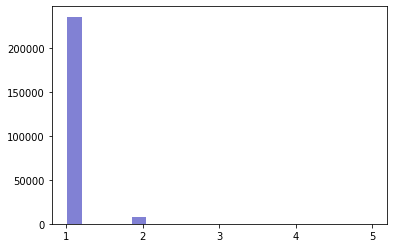

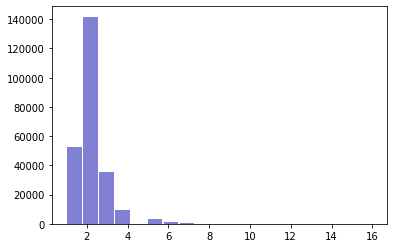

In [11]:
#######################################################################
## Histogram of n8k and nitem ########### much quicker in STATA #######
#######################################################################
n, bins, patches = plt.hist(crsp_comp_edgar['n8k'], bins='auto', color='#0504aa', alpha=0.5, rwidth=0.9)
plt.locator_params(axis='x', integer=True)
plt.show()
n, bins, patches = plt.hist(crsp_comp_edgar['nitem'], bins='auto', color='#0504aa', alpha=0.5, rwidth=0.9)
plt.locator_params(axis='x', integer=True)
plt.show()

<Figure size 432x288 with 0 Axes>

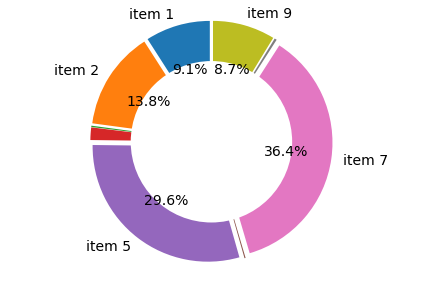

<Figure size 432x288 with 0 Axes>

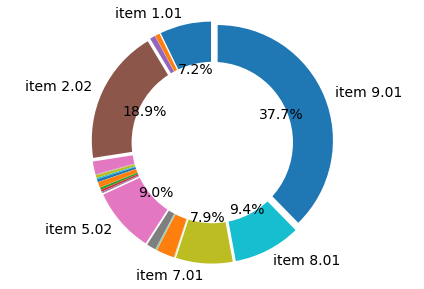

In [12]:
############################################
####### Appendix A: 8-K item pie chart #####
############################################
n_item_before2004 = crsp_comp_edgar.loc[:,item_before2004].sum().values.tolist()
n_item_after2004 = crsp_comp_edgar.loc[:,item_after2004].sum().values.tolist()

pct_limit = 5

def plotGraph(data,label):
    fig = plt.figure()
    
    ### Plotting arrangements ###
    # Explsion
    explode = [0.05 for i in data]
    # Label constraint
    def my_autopct(pct):
        return ('%1.1f%%' % pct) if pct > pct_limit else ''

    total = 0
    for ele in range(0, len(data)): 
        total = total + data[ele]
    
    labels = [n.replace('_',' ') if v > total * pct_limit/100 else '' for n, v in zip(label, data)]    

    # Create pie chart
    fig, ax = plt.subplots()
    ax.pie(data, labels=labels, autopct=my_autopct, startangle=90, textprops={'color':"black", 'fontsize': 14}, explode = explode)

    # Draw inner circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax.axis('equal')  
    plt.tight_layout()
    
    return fig

plot1 = plotGraph(n_item_before2004, item_before2004)
plot2 = plotGraph(n_item_after2004, item_after2004)

plot1.savefig(r'..\output\fig\fig1_8-K_before.png', format = 'png')
plot2.savefig(r'..\output\fig\fig1_8-K_after.png', format = 'png')